<Figure size 432x288 with 0 Axes>

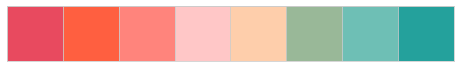

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.display.precision = 15

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)
colp = ['#e84a5f','#ff5f40','#ff847c','#ffc7c7','#feceab','#99b898','#6ebfb5','#24a19c']
sns.palplot(sns.color_palette(colp))

from tqdm import tqdm_notebook

from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2

import pydicom # for DICOM images
from skimage.transform import resize


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


import warnings
warnings.filterwarnings("ignore")
import time

In [2]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [3]:
def reduce_df_size(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
"""
            Describe data and difference between train and test datasets.

            
Arguments :-
feattoExcl = Features in training set not to be included for comparison

Example on how to use :-
 dfi, _, _ = fit_describe_infos(train, test,featToExcl=['target'])
dfi
"""

def df_explained(train, test, featToExcl = []):
    stats = []
    __featToAnalyze = [v for v in list(train.columns) if v not in featToExcl]


    for col in tqdm_notebook(__featToAnalyze):
            
        dtrain = dict(train[col].value_counts())
        dtest = dict(test[col].value_counts())

        set_train_not_in_test = set(dtest.keys()) - set(dtrain.keys())
        set_test_not_in_train = set(dtrain.keys()) - set(dtest.keys())
        
        dict_train_not_in_test = {key:value for key, value in dtest.items() if key in set_train_not_in_test}
        dict_test_not_in_train = {key:value for key, value in dtrain.items() if key in set_test_not_in_train}
            
        nb_moda_test, nb_var_test = len(dtest), pd.Series(dtest).sum()
        nb_moda_abs, nb_var_abs = len(dict_train_not_in_test), pd.Series(dict_train_not_in_test).sum()
        nb_moda_train, nb_var_train = len(dtrain), pd.Series(dtrain).sum()
        nb_moda_abs_2, nb_var_abs_2 = len(dict_test_not_in_train), pd.Series(dict_test_not_in_train).sum()
        
            
        stats.append((col, train[col].nunique()
            , str(nb_moda_abs) + '   (' + str(round(100 * nb_moda_abs / nb_moda_test, 1))+'%)'
            , str(nb_moda_abs_2) +'   (' + str(round(100 * nb_moda_abs_2 / nb_moda_train, 1))+'%)'
            , str(train[col].isnull().sum()) +'   (' + str(round(100 * train[col].isnull().sum() / train.shape[0], 1))+'%)'
            , str(test[col].isnull().sum()) +'   (' + str(round(100 * test[col].isnull().sum() / test.shape[0], 1))+'%)'
            , str(round(100 * train[col].value_counts(normalize = True, dropna = False).values[0], 1))
            , train[col].dtype))
            
    df_stats = pd.DataFrame(stats, columns=['Feature',
        'Unique values (train)', 
        "Unique values in test not in train (and %)",
        "Unique values in train not in test (and %)",
        'NaN in train (and %)', 'NaN in test (and %)', 
        '% in the biggest cat. (train)',
        'dtype'])
    
    
            
    return df_stats, dict_train_not_in_test, dict_test_not_in_train

def corr_matrix(df,s):
    print("*****************")
    print((df.corr()[s]).sort_values(ascending=False))
    print("*****************")
    cor_mat= df[:].corr()
    mask = np.array(cor_mat)
    mask[np.tril_indices_from(mask)] = False
    fig=plt.gcf()
    fig.set_size_inches(30,12)
    sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)



def read_pd(s):
    df = pd.read_csv(s)
    df = reduce_df_size(df)
    print("Shape of the DataFrame is : ",df.shape)
    return df





In [5]:
list(os.listdir('../input/siim-isic-melanoma-classification'))

['tfrecords',
 'train.csv',
 'train',
 'test',
 'test.csv',
 'sample_submission.csv',
 'jpeg']

In [6]:
trd = read_pd('/kaggle/input/siim-isic-melanoma-classification/train.csv')
ted = read_pd('/kaggle/input/siim-isic-melanoma-classification/test.csv')

Mem. usage decreased to  1.61 Mb (20.3% reduction)
Shape of the DataFrame is :  (33126, 8)
Mem. usage decreased to  0.36 Mb (15.0% reduction)
Shape of the DataFrame is :  (10982, 5)


In [7]:
trd

image_name  patient_id     sex  age_approx  \
0      ISIC_2637011  IP_7279968    male        45.0   
1      ISIC_0015719  IP_3075186  female        45.0   
2      ISIC_0052212  IP_2842074  female        50.0   
3      ISIC_0068279  IP_6890425  female        45.0   
4      ISIC_0074268  IP_8723313  female        55.0   
...             ...         ...     ...         ...   
33121  ISIC_9999134  IP_6526534    male        50.0   
33122  ISIC_9999320  IP_3650745    male        65.0   
33123  ISIC_9999515  IP_2026598    male        20.0   
33124  ISIC_9999666  IP_7702038    male        50.0   
33125  ISIC_9999806  IP_0046310    male        45.0   

      anatom_site_general_challenge diagnosis benign_malignant  target  
0                         head/neck   unknown           benign       0  
1                   upper extremity   unknown           benign       0  
2                   lower extremity     nevus           benign       0  
3                         head/neck   unknown           benign       0  
4                   upper extremity   unknown           benign       0  
...                             ...       ...              ...     ...  
33121                         torso   unknown           benign       0  
33122                         torso   unknown           benign       0  
33123               lower extremity   unknown           benign       0  
33124               lower extremity   unknown           benign       0  
33125                         torso     nevus           benign       0  

[33126 rows x 8 columns]

In [8]:
ted

image_name  patient_id     sex  age_approx  \
0      ISIC_0052060  IP_3579794    male        70.0   
1      ISIC_0052349  IP_7782715    male        40.0   
2      ISIC_0058510  IP_7960270  female        55.0   
3      ISIC_0073313  IP_6375035  female        50.0   
4      ISIC_0073502  IP_0589375  female        45.0   
...             ...         ...     ...         ...   
10977  ISIC_9992485  IP_4152479    male        40.0   
10978  ISIC_9996992  IP_4890115    male        35.0   
10979  ISIC_9997917  IP_2852390    male        25.0   
10980  ISIC_9998234  IP_8861963    male        65.0   
10981  ISIC_9999302  IP_6214039    male        30.0   

      anatom_site_general_challenge  
0                               NaN  
1                   lower extremity  
2                             torso  
3                             torso  
4                   lower extremity  
...                             ...  
10977                         torso  
10978                         torso  
10979               upper extremity  
10980               lower extremity  
10981               upper extremity  

[10982 rows x 5 columns]

In [9]:
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
trd.columns = new_names
ted.columns = new_names[:5]

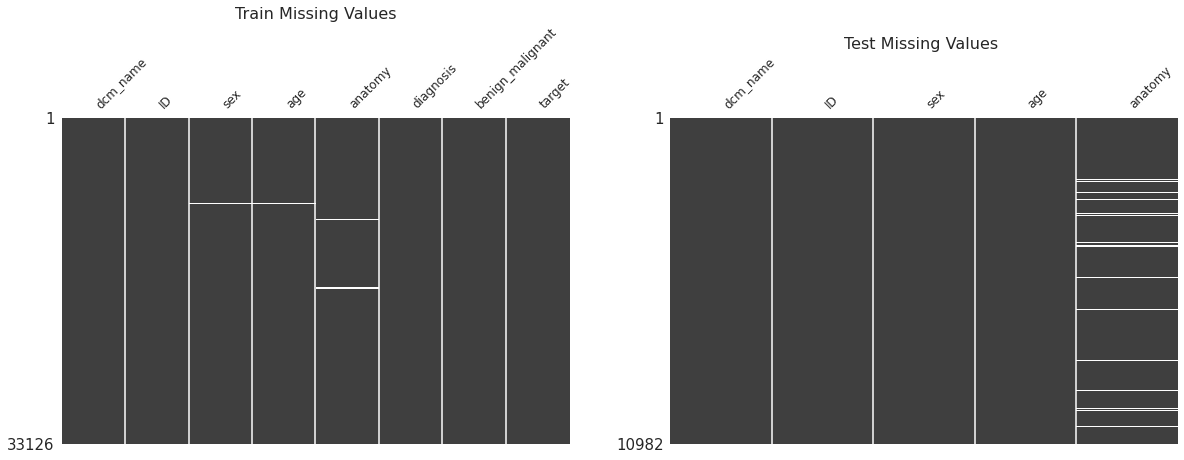

In [10]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

msno.matrix(trd, ax = ax[0], fontsize=12)
msno.matrix(ted, ax = ax[1], fontsize=12)

ax[0].set_title('Train Missing Values', fontsize = 16)
ax[1].set_title('Test Missing Values ', fontsize = 16);

In [11]:
df_explained(trd.drop(columns = ['diagnosis', 'benign_malignant', 'target']),ted)[0]

Feature  Unique values (train) Unique values in test not in train (and %)  \
0  dcm_name                  33126                           10982   (100.0%)   
1        ID                   2056                             690   (100.0%)   
2       sex                      2                                 0   (0.0%)   
3       age                     18                                 0   (0.0%)   
4   anatomy                      6                                 0   (0.0%)   

  Unique values in train not in test (and %) NaN in train (and %)  \
0                           33126   (100.0%)           0   (0.0%)   
1                            2056   (100.0%)           0   (0.0%)   
2                                 0   (0.0%)          65   (0.2%)   
3                                 1   (5.6%)          68   (0.2%)   
4                                 0   (0.0%)         527   (1.6%)   

  NaN in test (and %) % in the biggest cat. (train)    dtype  
0          0   (0.0%)                           0.0   object  
1          0   (0.0%)                           0.3   object  
2          0   (0.0%)                          51.6   object  
3          0   (0.0%)                          13.5  float16  
4        351   (3.2%)                          50.9   object

Text(0.5, 1.0, 'Missing Values in train')

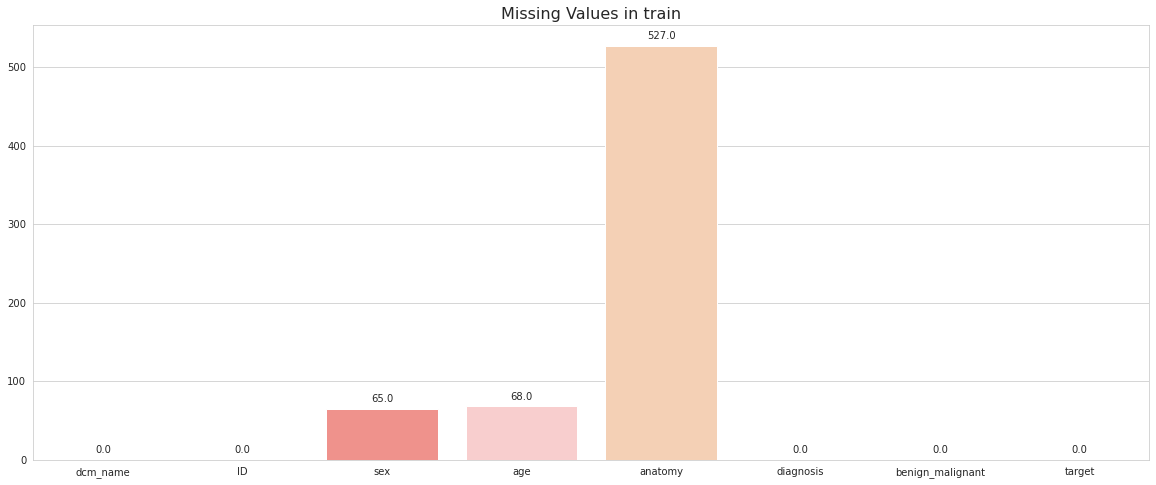

In [12]:
f,ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x=trd.isna().sum().index,y=trd.isna().sum().values,palette = colp)

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
ax.set_title("Missing Values in train",fontsize=16)

Text(0.5, 1.0, 'Missing Values in test')

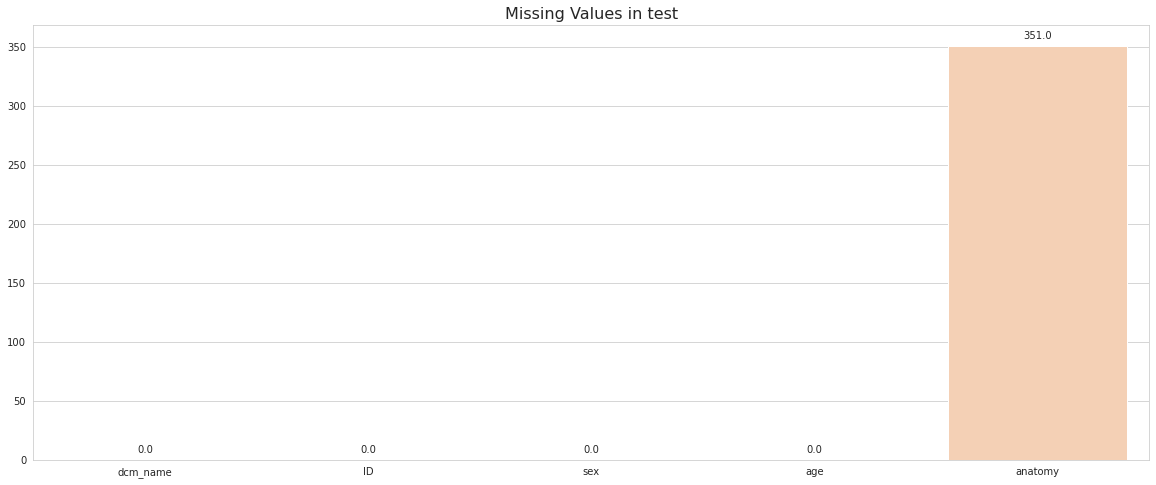

In [13]:
f,ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x=ted.isna().sum().index,y=ted.isna().sum().values,palette = colp)

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
ax.set_title("Missing Values in test",fontsize=16)

Text(0.5, 1.0, 'Count of Anatomy')

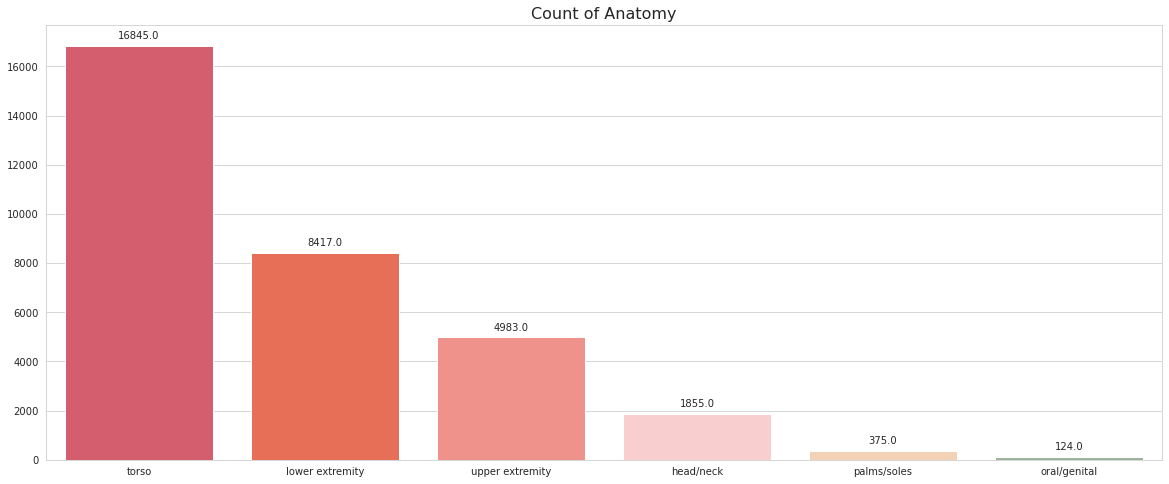

In [14]:
f,ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x=trd['anatomy'].value_counts().index,y=trd['anatomy'].value_counts().values,palette = colp)

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
ax.set_title("Count of Anatomy",fontsize=16)

Text(0.5, 1.0, 'Count of Anatomy')

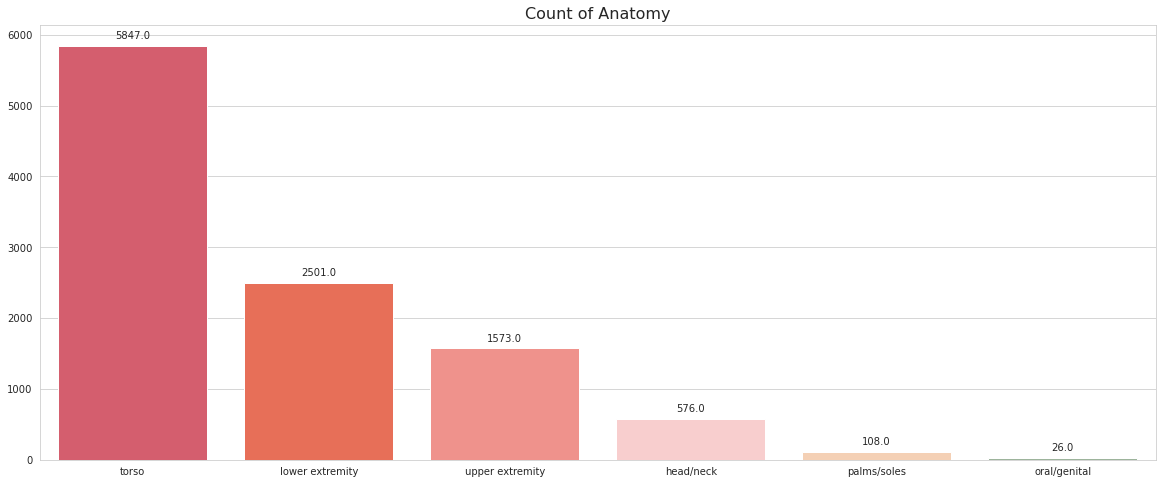

In [15]:
f,ax = plt.subplots(figsize=(20,8))
splot = sns.barplot(x=ted['anatomy'].value_counts().index,y=ted['anatomy'].value_counts().values,palette = colp)

for p in splot.patches:
    splot.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
ax.set_title("Count of Anatomy",fontsize=16)

Out of 65 NAN values, 65 are benign and 0 malignant.


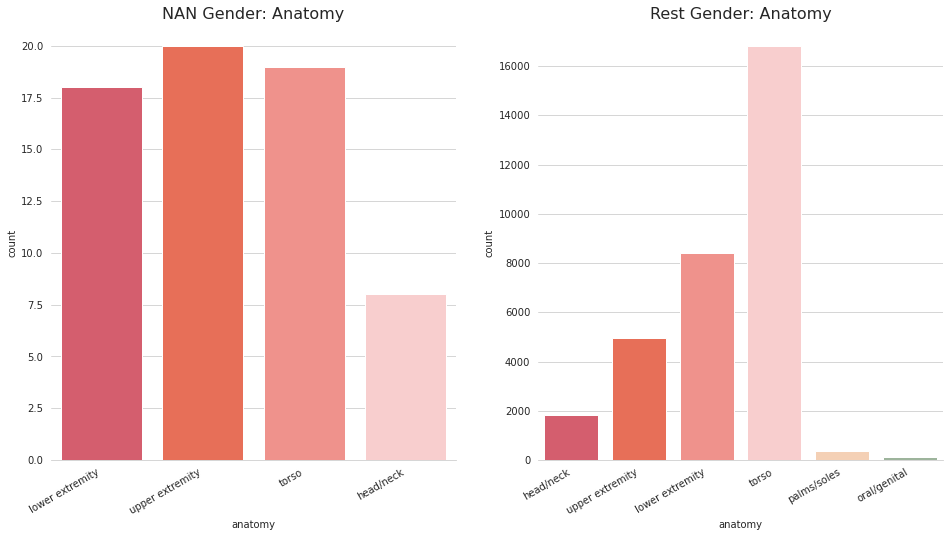

In [16]:
na_sex = trd[trd['sex'].isna() == True]
is_sex = trd[trd['sex'].isna() == False]


f, ax = plt.subplots(1, 2, figsize = (16, 8))

a = sns.countplot(na_sex['anatomy'], ax = ax[0],palette=colp)
b = sns.countplot(is_sex['anatomy'], ax = ax[1],palette =colp)
ax[0].set_title('NAN Gender: Anatomy', fontsize=16)
ax[1].set_title('Rest Gender: Anatomy', fontsize=16)


a.set_xticklabels(a.get_xticklabels(), rotation=30, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=30, ha="right")
sns.despine(left=True)

print('Out of 65 NAN values, {} are benign and {} malignant.'.format(na_sex['benign_malignant'].value_counts()[0],65 - na_sex['benign_malignant'].value_counts()[0]))



In [17]:
Anatomy = ['lower extremity', 'upper extremity', 'torso']
trd[ ( trd['anatomy'].isin(Anatomy) & (trd['target']==0) ) ]['sex'].value_counts()

male      15173
female    14523
Name: sex, dtype: int64

In [18]:
trd['sex'].fillna("male",inplace = True)

Out of 68 NAN values, 68 are benign and 0 malignant.


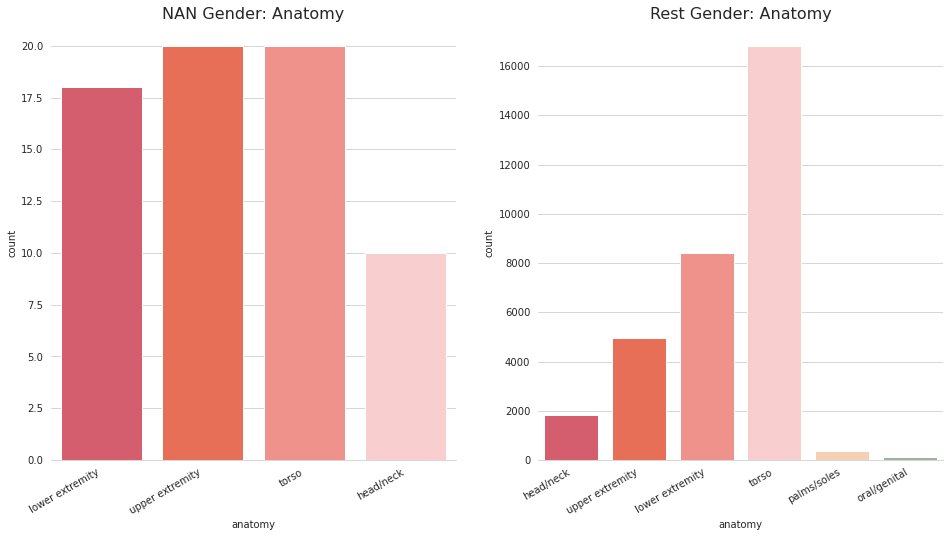

In [19]:
na_age = trd[trd['age'].isna() == True]
is_age = trd[trd['age'].isna() == False]


f, ax = plt.subplots(1, 2, figsize = (16, 8))

a = sns.countplot(na_age['anatomy'], ax = ax[0],palette=colp)
b = sns.countplot(is_age['anatomy'], ax = ax[1],palette =colp)
ax[0].set_title('NAN Gender: Anatomy', fontsize=16)
ax[1].set_title('Rest Gender: Anatomy', fontsize=16)


a.set_xticklabels(a.get_xticklabels(), rotation=30, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=30, ha="right")
sns.despine(left=True)

print('Out of 68 NAN values, {} are benign and {} malignant.'.format(na_age['benign_malignant'].value_counts()[0],68 - na_age['benign_malignant'].value_counts()[0]))



In [20]:
Age = ['lower extremity', 'upper extremity', 'torso']
median = trd[ ( trd['anatomy'].isin(Age) & (trd['target']==0) ) ]['age'].median()
median

50.0

In [21]:
trd['age'].fillna(median,inplace=True)

Amongst all missing values, 518 are benign and 9 malignant.


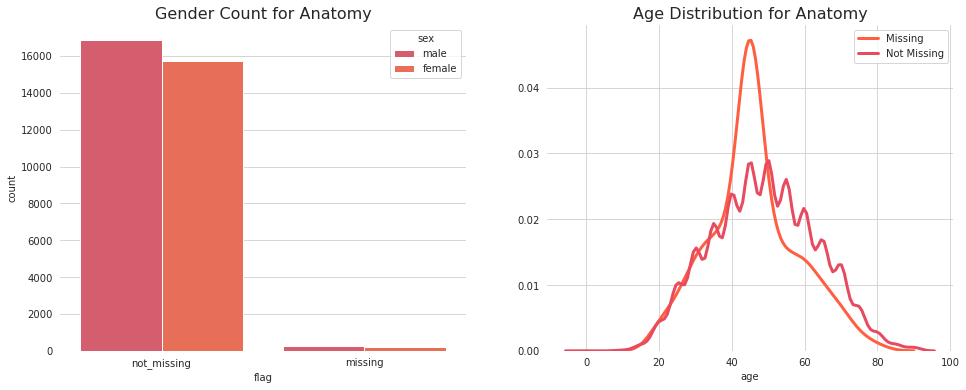

In [22]:
anatomy = trd.copy()
anatomy['flag'] = np.where(trd['anatomy'].isna()==True, 'missing', 'not_missing')


f, ax = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax[0], palette=colp)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age'], hist=False, label='Missing', ax=ax[1] , 
             color=colp[1] , kde_kws= {'lw' : 3} )

sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age'], hist=False, label='Not Missing', ax=ax[1] , 
             color=colp[0] , kde_kws= {'lw' : 3} )

ax[0].set_title('Gender Count for Anatomy', fontsize=16)
ax[1].set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);


be_ma = anatomy[anatomy['flag'] == 'missing']['benign_malignant'].value_counts()
print('Amongst all missing values, {} are benign and {} malignant.'.format(be_ma[0], be_ma[1]))

In [23]:
trd['anatomy'].fillna('torso',inplace = True)

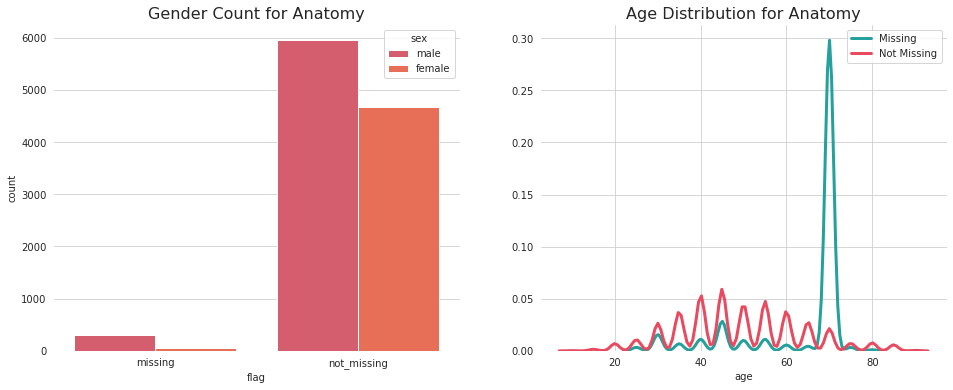

In [24]:
anatomy = ted.copy()
anatomy['flag'] = np.where(ted['anatomy'].isna()==True, 'missing', 'not_missing')


f, ax = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax[0], palette=colp)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age'], hist=False, label='Missing', ax=ax[1] , 
             color=colp[7] , kde_kws= {'lw' : 3,'bw':1} )

sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age'], hist=False, label='Not Missing', ax=ax[1] , 
             color=colp[0] , kde_kws= {'lw' : 3,'bw':1} )

ax[0].set_title('Gender Count for Anatomy', fontsize=16)
ax[1].set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);



In [25]:
max_freq_anatomy = ted[ted['age'] == 70]['anatomy'].mode()[0]
max_freq_anatomy

'torso'

In [26]:
ted['anatomy'].fillna('max_freq_anatomy',inplace = True)

In [27]:
trd.to_csv('trd_eda1.csv',index = True)
ted.to_csv('ted_eda1.csv',index = True)

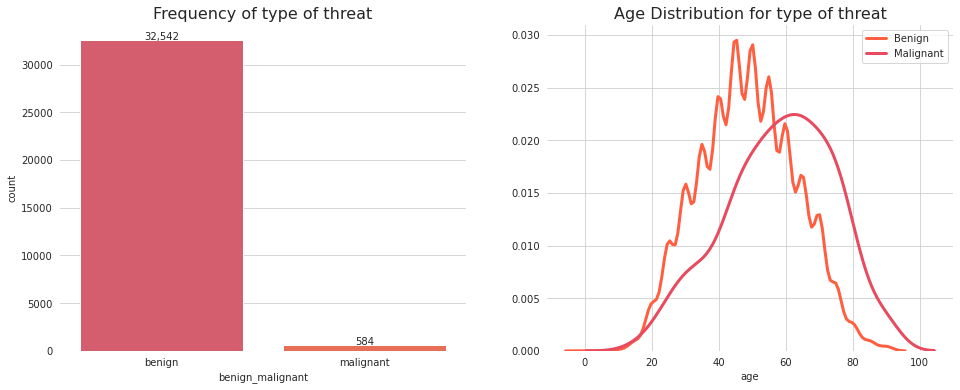

In [28]:
f, ax = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(x = trd['benign_malignant'], ax=ax[0], palette=colp)

sns.distplot(trd[trd['benign_malignant'] == 'benign']['age'], hist=False, label='Benign', ax=ax[1] , 
             color=colp[1] , kde_kws= {'lw' : 3} )

sns.distplot(trd[trd['benign_malignant'] == 'malignant']['age'], hist=False, label='Malignant', ax=ax[1] , 
             color=colp[0] , kde_kws= {'lw' : 3} )

ax[0].set_title('Frequency of type of threat', fontsize=16)
ax[1].set_title('Age Distribution for type of threat', fontsize=16)
sns.despine(left=True, bottom=True);


for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

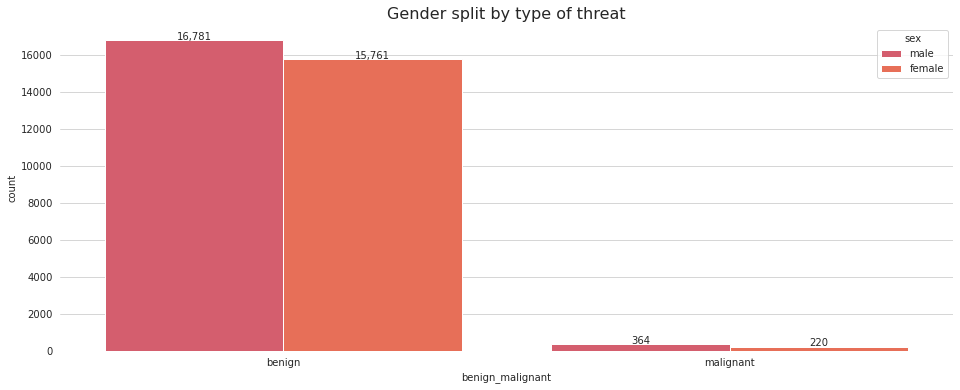

In [29]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=trd, x='benign_malignant', hue='sex', palette=colp)

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by type of threat', fontsize=16)
sns.despine(left=True, bottom=True);

Text(0.5, 1.0, 'Diagnosis Count plot')

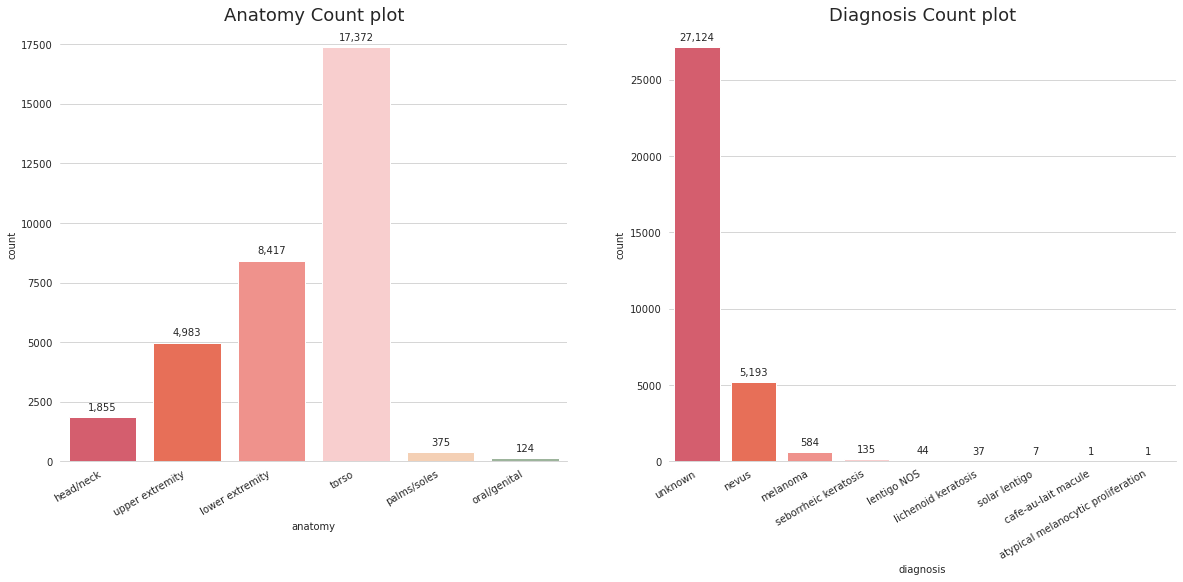

In [30]:
f , ax = plt.subplots( 1, 2, figsize=(20,8))

a = sns.countplot(trd['anatomy'],ax = ax[0],palette = colp)
b = sns.countplot(trd['diagnosis'],ax = ax[1],palette = colp)

a.set_xticklabels(a.get_xticklabels(), rotation=30, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=30, ha="right")

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 10), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 10), textcoords = 'offset points')

sns.despine(left = True)

ax[0].set_title("Anatomy Count plot",fontsize = 18)
ax[1].set_title("Diagnosis Count plot",fontsize = 18)



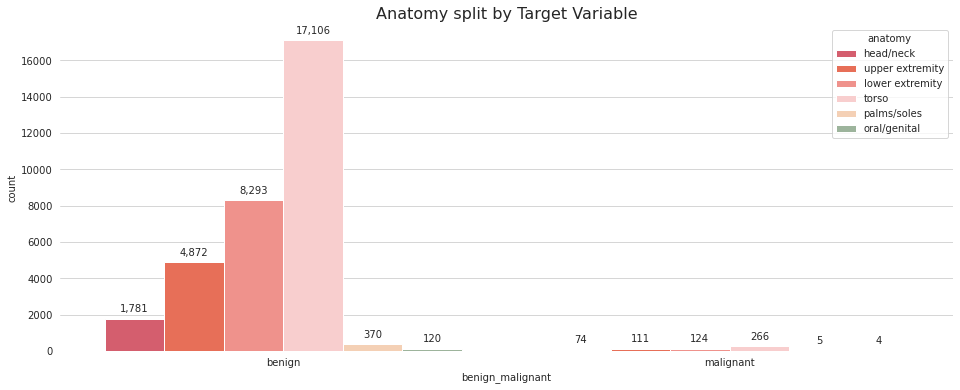

In [31]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=trd, x='benign_malignant', hue='anatomy', palette=colp)

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 10), textcoords = 'offset points')

plt.title('Anatomy split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

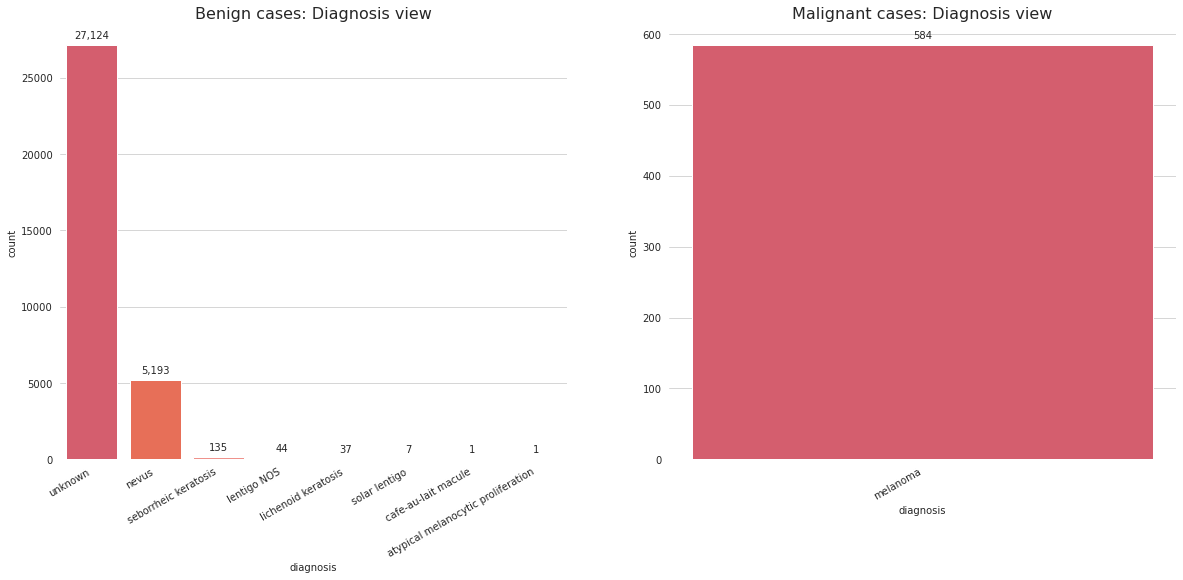

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))

a = sns.countplot(trd[trd['target']==0]['diagnosis'], ax=ax1, palette = colp)
b = sns.countplot(trd[trd['target']==1]['diagnosis'], ax=ax2, palette = colp)

a.set_xticklabels(a.get_xticklabels(), rotation=30, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=30, ha="right")

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 10), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 10), textcoords = 'offset points')
    
ax1.set_title('Benign cases: Diagnosis view', fontsize=16)
ax2.set_title('Malignant cases: Diagnosis view', fontsize=16)
sns.despine(left=True, bottom=True);


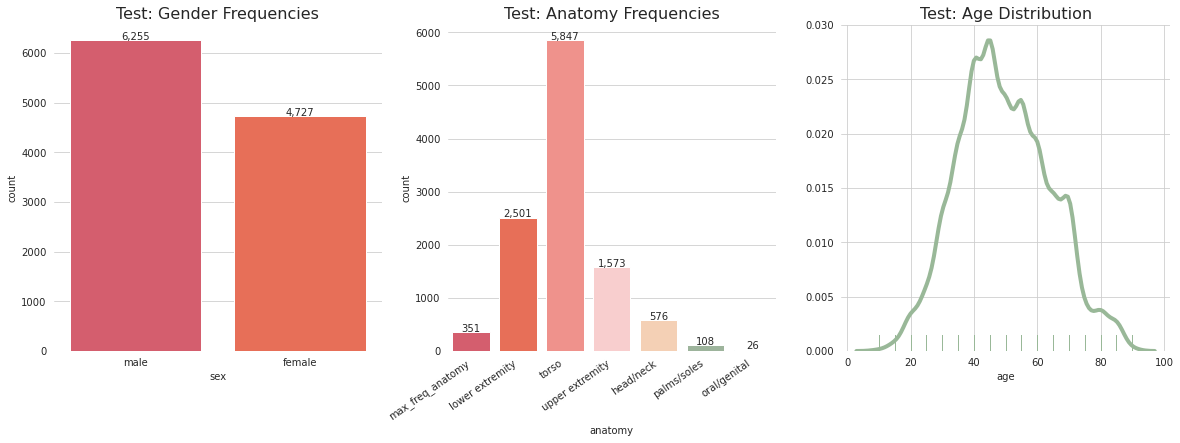

In [33]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6))

a = sns.countplot(ted['sex'], palette=colp, ax=ax1)
b = sns.countplot(ted['anatomy'], ax=ax2, palette = colp)
c = sns.distplot(a = ted['age'], ax=ax3, color=colp[5], 
                 hist=False, rug=True, kde_kws={'lw':4})

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

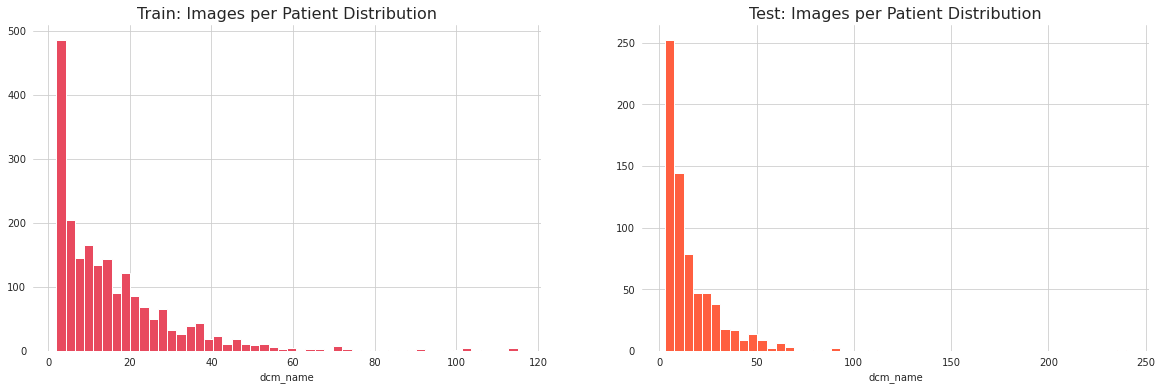

In [34]:
patients_count_train = trd.groupby(by='ID')['dcm_name'].count().reset_index()
patients_count_test = ted.groupby(by='ID')['dcm_name'].count().reset_index()

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

a = sns.distplot(patients_count_train['dcm_name'], kde=False, bins=50, 
                 ax=ax1, color=colp[0], hist_kws={'alpha': 1})
b = sns.distplot(patients_count_test['dcm_name'], kde=False, bins=50, 
                 ax=ax2, color=colp[1], hist_kws={'alpha': 1})
    
ax1.set_title('Train: Images per Patient Distribution', fontsize=16)
ax2.set_title('Test: Images per Patient Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

In [35]:
trd.to_csv('trd_eda2.csv', index=False)
ted.to_csv('ted_eda2.csv', index=False)


In [36]:
directory = '../input/siim-isic-melanoma-classification'

train_path = directory + '/train/' + trd['dcm_name'] +'.dcm'
test_path = directory + '/test/' + ted['dcm_name'] + '.dcm'

trd['path_discom'] = train_path
ted['path_discom'] = test_path

train_path = directory + '/jpeg/train/' + trd['dcm_name'] +'.jpg'
test_path = directory + '/jpeg/test/' + ted['dcm_name'] + '.jpg'

trd['path_jpeg'] = train_path
ted['path_jpeg'] = test_path

In [37]:
trd

dcm_name          ID     sex   age          anatomy diagnosis  \
0      ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1      ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2      ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3      ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4      ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   
...             ...         ...     ...   ...              ...       ...   
33121  ISIC_9999134  IP_6526534    male  50.0            torso   unknown   
33122  ISIC_9999320  IP_3650745    male  65.0            torso   unknown   
33123  ISIC_9999515  IP_2026598    male  20.0  lower extremity   unknown   
33124  ISIC_9999666  IP_7702038    male  50.0  lower extremity   unknown   
33125  ISIC_9999806  IP_0046310    male  45.0            torso     nevus   

      benign_malignant  target  \
0               benign       0   
1               benign       0   
2               benign       0   
3               benign       0   
4               benign       0   
...                ...     ...   
33121           benign       0   
33122           benign       0   
33123           benign       0   
33124           benign       0   
33125           benign       0   

                                             path_discom  \
0      ../input/siim-isic-melanoma-classification/tra...   
1      ../input/siim-isic-melanoma-classification/tra...   
2      ../input/siim-isic-melanoma-classification/tra...   
3      ../input/siim-isic-melanoma-classification/tra...   
4      ../input/siim-isic-melanoma-classification/tra...   
...                                                  ...   
33121  ../input/siim-isic-melanoma-classification/tra...   
33122  ../input/siim-isic-melanoma-classification/tra...   
33123  ../input/siim-isic-melanoma-classification/tra...   
33124  ../input/siim-isic-melanoma-classification/tra...   
33125  ../input/siim-isic-melanoma-classification/tra...   

                                               path_jpeg  
0      ../input/siim-isic-melanoma-classification/jpe...  
1      ../input/siim-isic-melanoma-classification/jpe...  
2      ../input/siim-isic-melanoma-classification/jpe...  
3      ../input/siim-isic-melanoma-classification/jpe...  
4      ../input/siim-isic-melanoma-classification/jpe...  
...                                                  ...  
33121  ../input/siim-isic-melanoma-classification/jpe...  
33122  ../input/siim-isic-melanoma-classification/jpe...  
33123  ../input/siim-isic-melanoma-classification/jpe...  
33124  ../input/siim-isic-melanoma-classification/jpe...  
33125  ../input/siim-isic-melanoma-classification/jpe...  

[33126 rows x 10 columns]

In [38]:
ted

dcm_name          ID     sex   age           anatomy  \
0      ISIC_0052060  IP_3579794    male  70.0  max_freq_anatomy   
1      ISIC_0052349  IP_7782715    male  40.0   lower extremity   
2      ISIC_0058510  IP_7960270  female  55.0             torso   
3      ISIC_0073313  IP_6375035  female  50.0             torso   
4      ISIC_0073502  IP_0589375  female  45.0   lower extremity   
...             ...         ...     ...   ...               ...   
10977  ISIC_9992485  IP_4152479    male  40.0             torso   
10978  ISIC_9996992  IP_4890115    male  35.0             torso   
10979  ISIC_9997917  IP_2852390    male  25.0   upper extremity   
10980  ISIC_9998234  IP_8861963    male  65.0   lower extremity   
10981  ISIC_9999302  IP_6214039    male  30.0   upper extremity   

                                             path_discom  \
0      ../input/siim-isic-melanoma-classification/tes...   
1      ../input/siim-isic-melanoma-classification/tes...   
2      ../input/siim-isic-melanoma-classification/tes...   
3      ../input/siim-isic-melanoma-classification/tes...   
4      ../input/siim-isic-melanoma-classification/tes...   
...                                                  ...   
10977  ../input/siim-isic-melanoma-classification/tes...   
10978  ../input/siim-isic-melanoma-classification/tes...   
10979  ../input/siim-isic-melanoma-classification/tes...   
10980  ../input/siim-isic-melanoma-classification/tes...   
10981  ../input/siim-isic-melanoma-classification/tes...   

                                               path_jpeg  
0      ../input/siim-isic-melanoma-classification/jpe...  
1      ../input/siim-isic-melanoma-classification/jpe...  
2      ../input/siim-isic-melanoma-classification/jpe...  
3      ../input/siim-isic-melanoma-classification/jpe...  
4      ../input/siim-isic-melanoma-classification/jpe...  
...                                                  ...  
10977  ../input/siim-isic-melanoma-classification/jpe...  
10978  ../input/siim-isic-melanoma-classification/jpe...  
10979  ../input/siim-isic-melanoma-classification/jpe...  
10980  ../input/siim-isic-melanoma-classification/jpe...  
10981  ../input/siim-isic-melanoma-classification/jpe...  

[10982 rows x 7 columns]

In [39]:
enc = LabelEncoderExt()

cols = ['sex','anatomy']
    
for col in cols:
    x = enc.fit(trd[col])
    trd[col] = x.transform(trd[col])
    ted[col] = x.transform(ted[col])
    


In [40]:
enc = LabelEncoder()
trd['diagnosis'] = enc.fit_transform(trd['diagnosis'])
trd.drop(columns = 'benign_malignant',inplace = True)

In [41]:
trd.to_csv('trd_eda3.csv', index=False)
ted.to_csv('ted_eda3.csv', index=False)


In [42]:
print('Train .dcm number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/train'))), '\n' +
      'Test .dcm number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/test'))), '\n' +
      'Train .jpeg number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/jpeg/train'))), '\n' +
      'Test .jpeg number of images:', len(list(os.listdir('../input/siim-isic-melanoma-classification/jpeg/test'))), '\n' +
      '-----------------------', '\n' +
      'There is the same number of images as in train/ test .csv datasets')

Train .dcm number of images: 33126 
Test .dcm number of images: 10982 
Train .jpeg number of images: 33126 
Test .jpeg number of images: 10982 
----------------------- 
There is the same number of images as in train/ test .csv datasets


In [43]:
from tqdm import tqdm_notebook as tqdm

In [44]:
shapes_train = []

for k, path in tqdm(enumerate(trd['path_jpeg'])):
    image = Image.open(path)
    shapes_train.append(image.size)
    
    if k>6000 : break

In [45]:
shapes_train = pd.DataFrame(data = shapes_train, columns = ['H', 'W'], dtype='object')
shapes_train['Size'] = '[' + shapes_train['H'].astype(str) + ', ' + shapes_train['W'].astype(str) + ']'

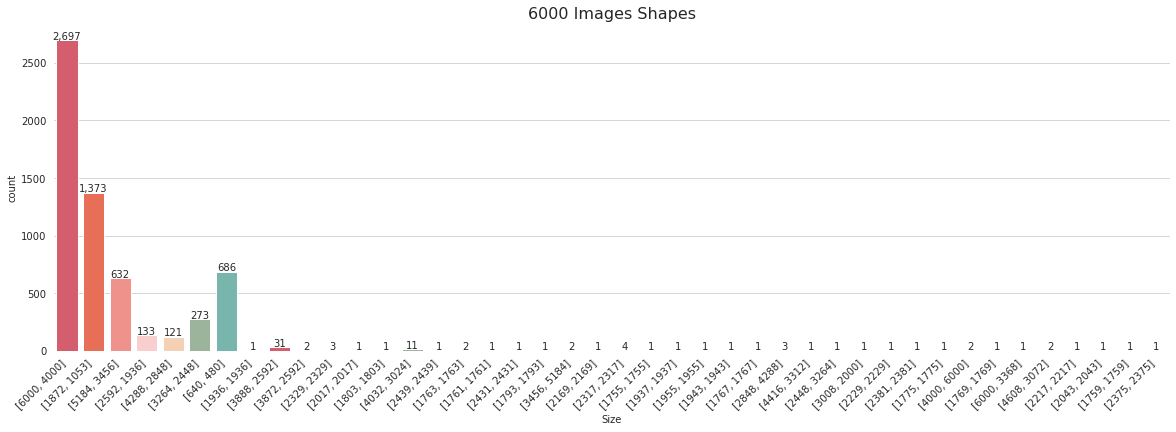

In [46]:
plt.figure(figsize = (20, 6))

a = sns.countplot(shapes_train['Size'], palette=colp)

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")
    
plt.title('6000 Images Shapes', fontsize=16)
sns.despine(left=True, bottom=True);

In [47]:
def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(20,6))

    for k, path in enumerate(data['path_discom'][:n]):
        image = pydicom.read_file(path)
        image = image.pixel_array
        
#         image = resize(image, (200, 200), anti_aliasing=True)

        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')

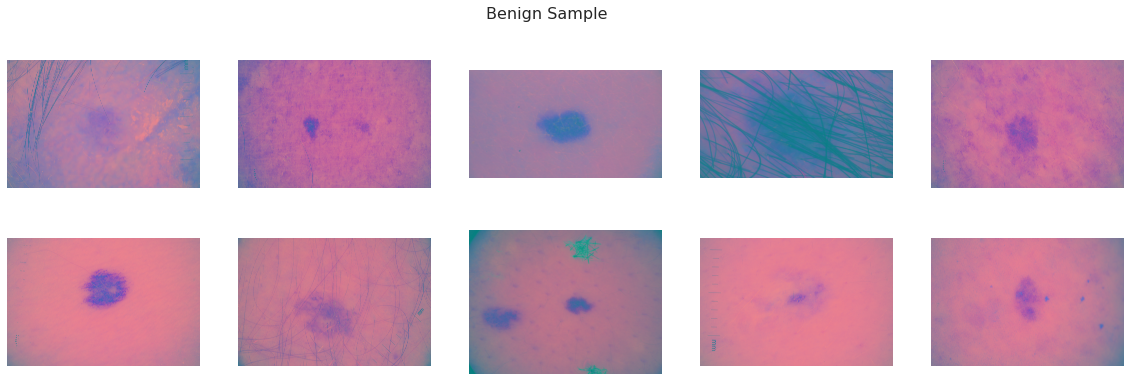

In [48]:
# Show Benign Samples
show_images(trd[trd['target'] == 0], n=10, rows=2, cols=5, title='Benign Sample')

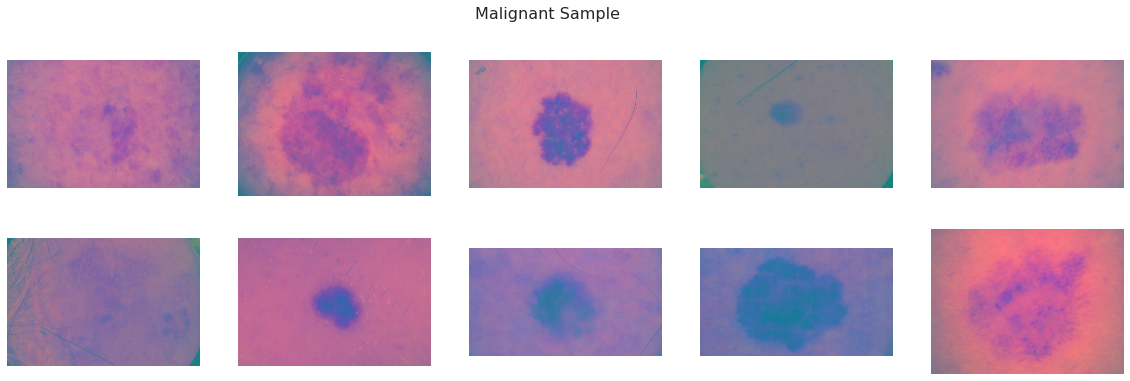

In [49]:
show_images(trd[trd['target'] == 1], n=10, rows=2, cols=5, title='Malignant Sample')

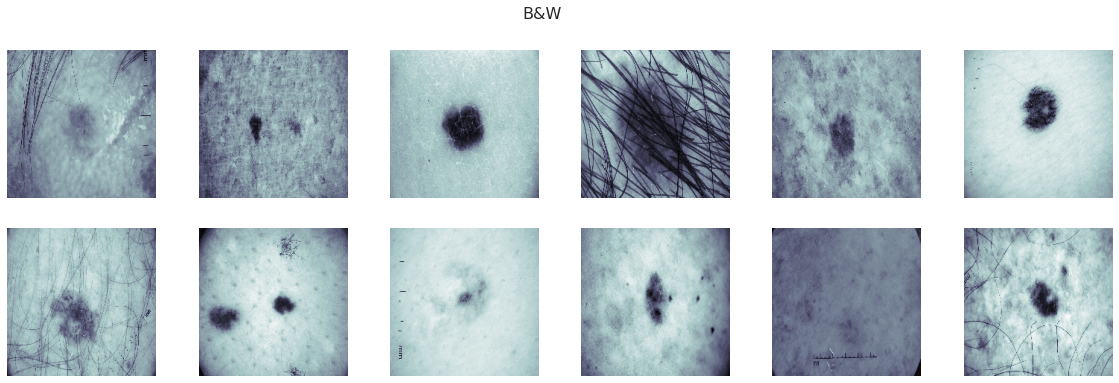

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,6))
plt.suptitle("B&W", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(trd['path_discom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')


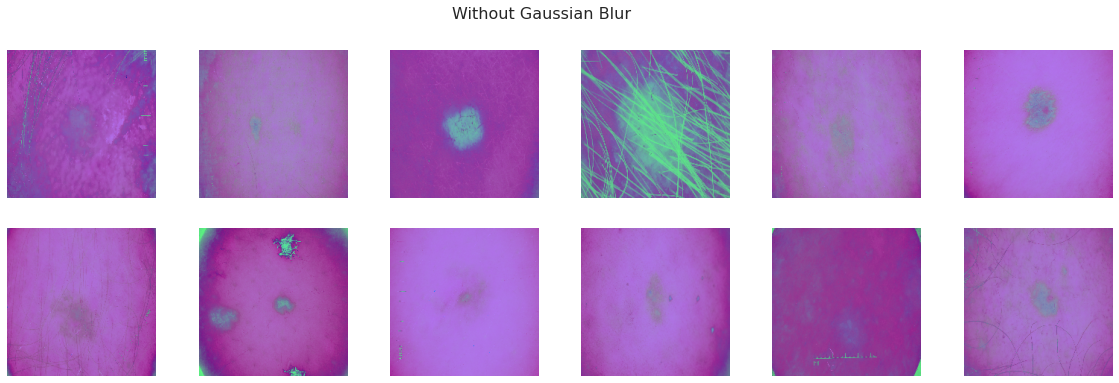

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,6))
plt.suptitle("Without Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(trd['path_discom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

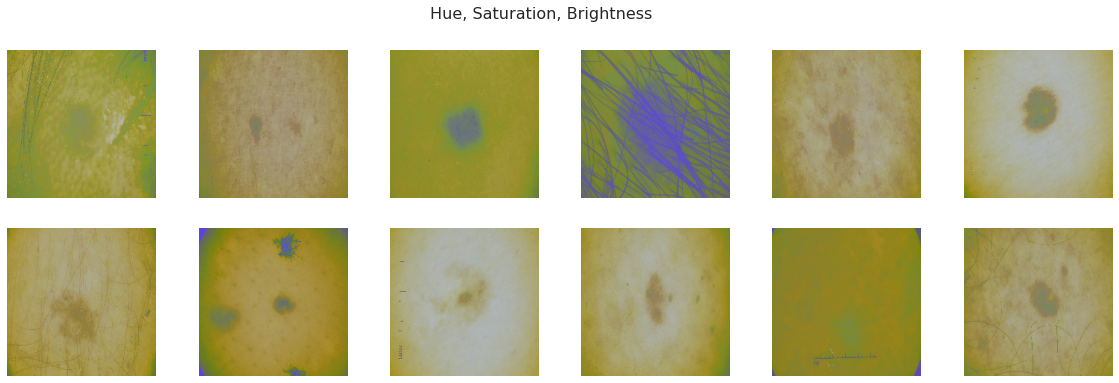

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,6))
plt.suptitle("Hue, Saturation, Brightness", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(trd['path_discom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

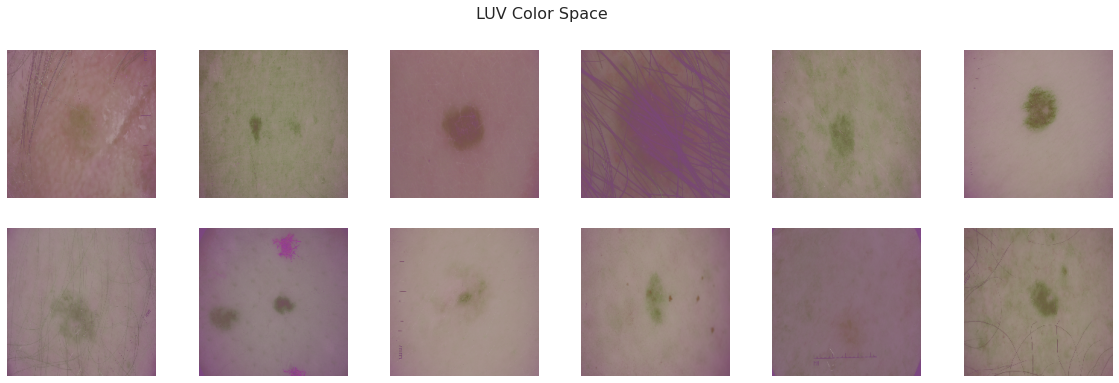

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,6))
plt.suptitle("LUV Color Space", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(trd['path_discom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')



In [54]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision

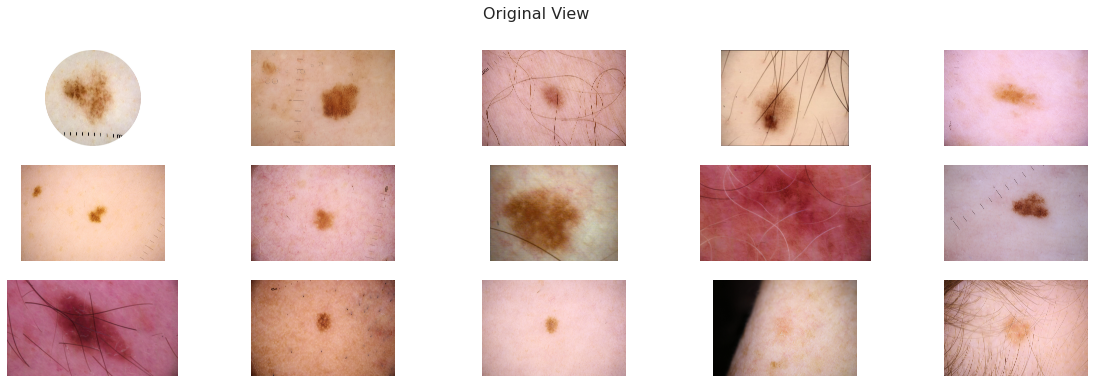

In [55]:
image_list = trd.sample(15)['path_jpeg']
image_list = image_list.reset_index()['path_jpeg']

# Show the sample
plt.figure(figsize=(20,6))
plt.suptitle("Original View", fontsize = 16)
    
for k, path in enumerate(image_list):
    image = mpimg.imread(path)
        
    plt.subplot(3, 5, k+1)
    plt.imshow(image)
    plt.axis('off')

In [56]:
class DatasetExample(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms
    
    # To get item's length
    def __len__(self):
        return (len(self.image_list))
    
    # For indexing
    def __getitem__(self, i):
        # Read in image
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')        
        image = np.asarray(image).astype(np.uint8)
        if self.transforms is not None:
            image = self.transforms(image)
            
        return torch.tensor(image, dtype=torch.float)



In [57]:
def show_transform(image, title="Default"):
    plt.figure(figsize=(16,6))
    plt.suptitle(title, fontsize = 16)
    
    # Unnormalize
    image = image / 2 + 0.5  
    npimg = image.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

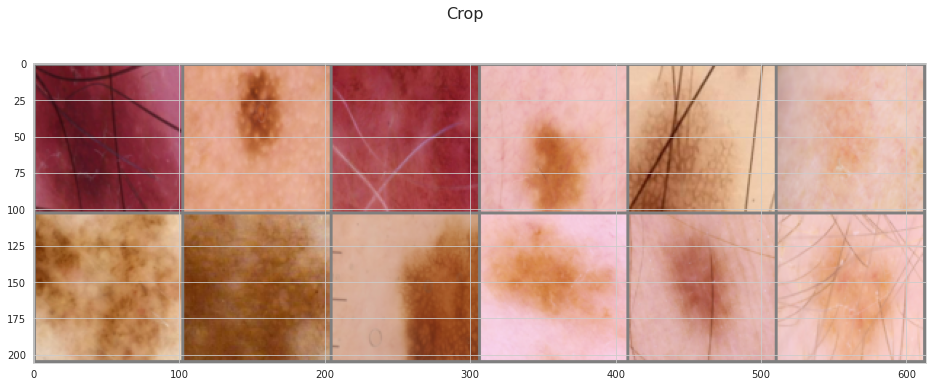

In [58]:
# Transform
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Crop")

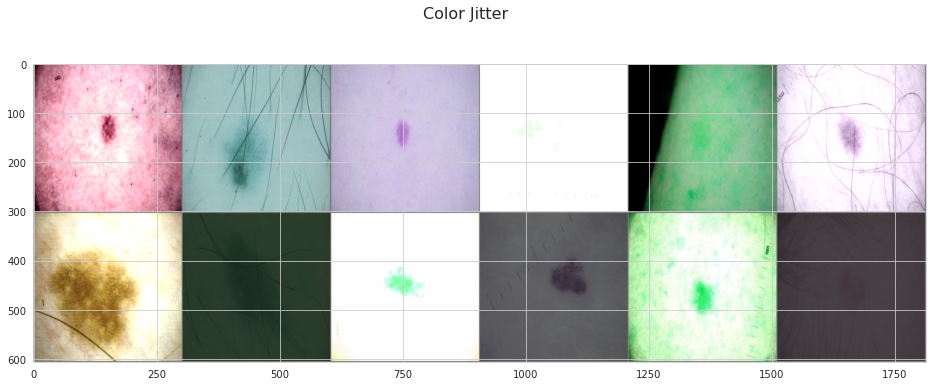

In [59]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Color Jitter")



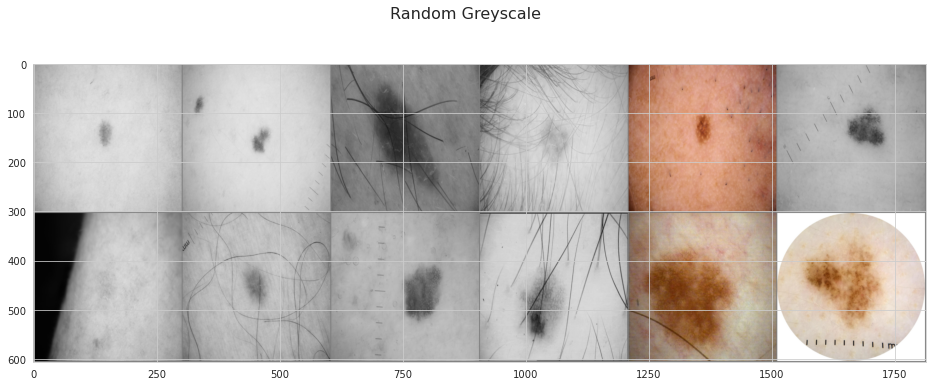

In [60]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.RandomGrayscale(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Random Greyscale")

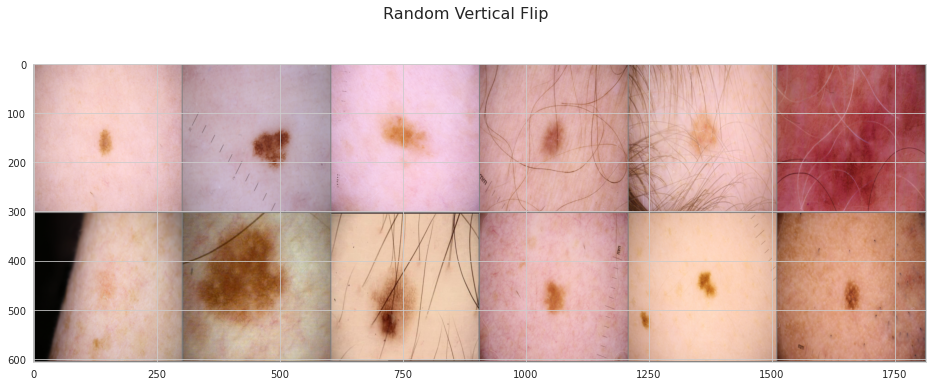

In [61]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.RandomVerticalFlip(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Random Vertical Flip")

In [62]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image


In [63]:
# Select a small sample of the .jpeg image paths
# We select some hairy photos on purpose
hairy_photos = trd[trd["sex"] == 1].reset_index().iloc[[12, 14, 17, 22, 33, 34]]
image_list = hairy_photos['path_jpeg']
image_list = image_list.reset_index()['path_jpeg']



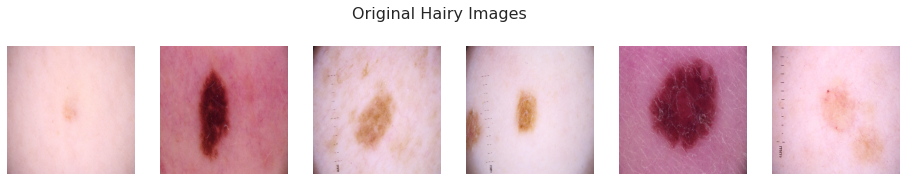

In [64]:
plt.figure(figsize=(16,3))
plt.suptitle("Original Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_list):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')

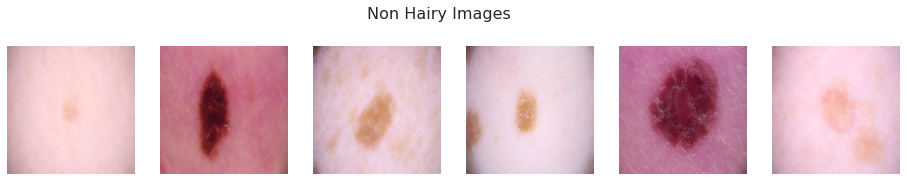

In [65]:
# Show the sample
plt.figure(figsize=(16,3))
plt.suptitle("Non Hairy Images", fontsize = 16)
    
for k, path in enumerate(image_list):
    image = mpimg.imread(path)
    image = cv2.resize(image,(300, 300))
    image = hair_remove(image)
        
    plt.subplot(1, 6, k+1)
    plt.imshow(image)
    plt.axis('off')
